<a href="https://colab.research.google.com/github/ianara01/Park-Sangjin/blob/master/VirtualScreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install DeepChem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 17.3 MB/s 
     |████████████████████████████████| 29.5 MB 70.1 MB/s 


In [2]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from deepchem.models import GraphConvModel

In [3]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from tqdm.auto import tqdm

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
active_df = pd.read_csv("https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/actives_final.ism",
                        header=None,sep=" ")
print(active_df.shape)
active_df[:3]

(79, 3)


,0,1,2
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683


In [6]:
active_rows, active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")

In [7]:
active_df[:3]

,SMILES,ID,ChEMBL_ID,label,Mol
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eebbc0>
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eee030>
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eee490>


In [8]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

In [9]:
add_property_columns_to_df(active_df)
active_df.head()

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eebbc0>,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eee030>,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eee490>,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eee4e0>,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,<rdkit.Chem.rdchem.Mol object at 0x7f1620eee580>,487.991,5.12922,0


In [10]:
decoy_df = pd.read_csv("https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/decoys_final.ism",
                       header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

In [11]:
decoy_df[:3]

,SMILES,ID,label,Mol,mw,logP,charge
0,C1COCCNC(=S)NCCOCCNC(=S)N1,C03897368,Decoy,<rdkit.Chem.rdchem.Mol object at 0x7f1620edf120>,292.430,-1.03860,0
1,c1cc(ccc1[C@H]2c3ccc(cc3OC(=C2C#N)N)N)O,C00242247,Decoy,<rdkit.Chem.rdchem.Mol object at 0x7f1620edf5d0>,279.299,2.19258,0
2,C[C@]12CC[C@H](C[C@@H]1CC[C@@H]3[C@@H]2C(=O)C[...,C04096778,Decoy,<rdkit.Chem.rdchem.Mol object at 0x7f1620edfc10>,366.498,1.65330,0


In [12]:
tmp_df = active_df.append(decoy_df)

In [13]:
tmp_df.shape

(4629, 8)

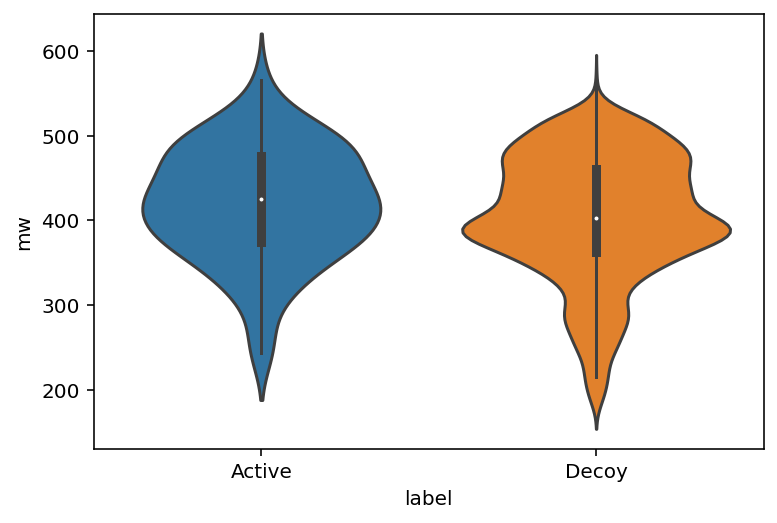

In [14]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["mw"]);

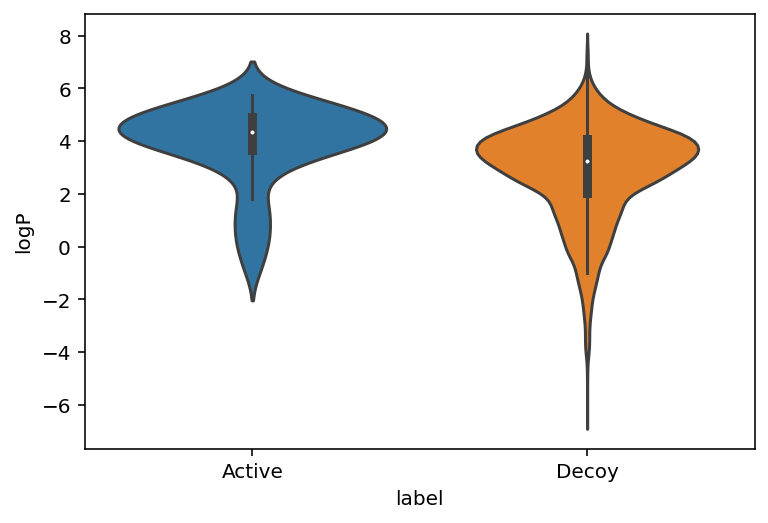

In [15]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["logP"]);

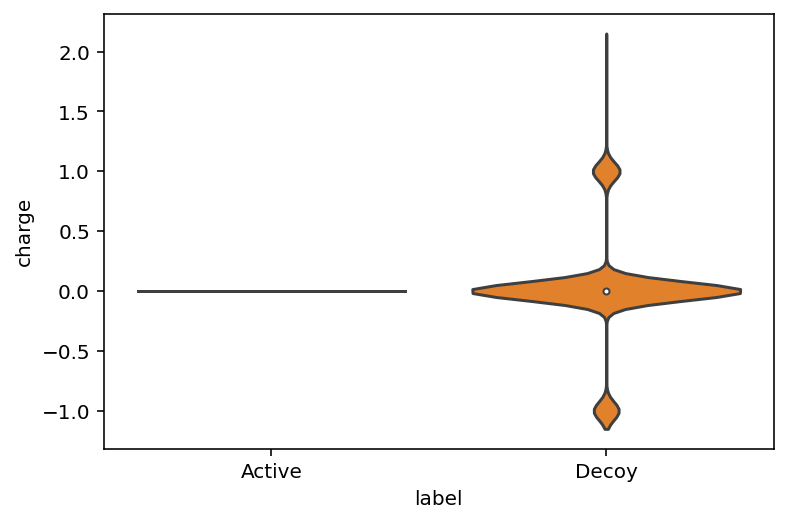

In [16]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["charge"]);

In [17]:
charged = decoy_df[decoy_df["charge"] != 0]

In [18]:
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177

In [19]:
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None

def NeutraliseCharges(smiles, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return (Chem.MolToSmiles(mol,True), True)
    else:
        return (smiles, False)

In [20]:
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()

In [21]:
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]

In [22]:
revised_decoy_df.shape

(4550, 3)

In [23]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

In [24]:
new_tmp_df = active_df.append(revised_decoy_df)

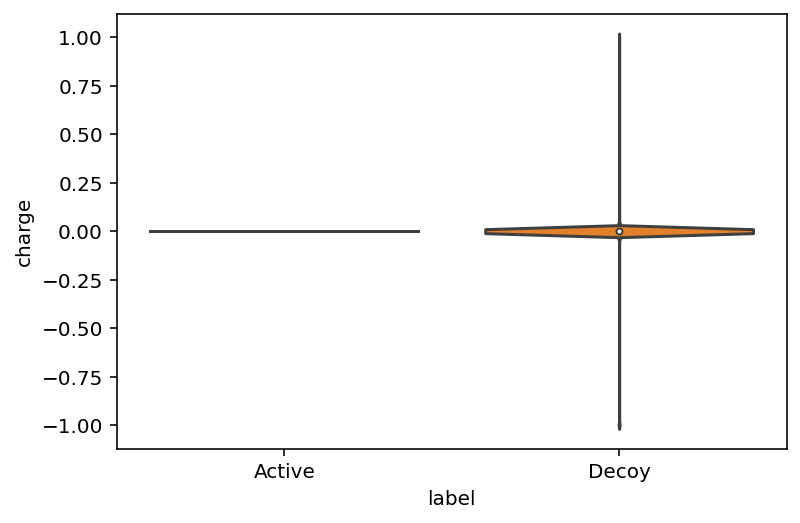

In [25]:
sns.violinplot(x=new_tmp_df["label"],y=new_tmp_df["charge"])

In [26]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0026373626373626374

In [27]:
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df)[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [28]:
# 파일로 저장해둔다
combined_df.to_csv("dude_erk1_mk01.csv")

In [29]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, 
             mode='classification', model_dir="./model_dir")
    return model

In [30]:
dataset_file = "dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

In [31]:
splitter = dc.splits.RandomSplitter()
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In [32]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5
for i in tqdm(range(0,cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[0.8928333917097626, 0.3112833940626828, 0.583542925751484, 0.9399721828403754, 0.6340753934422483]
[1.0, 0.0, 0.4967355472528167, 0.9025394689383894, 0.574840038738937]


In [33]:
# https://distill.pub/2021/gnn-intro/  gnn introduction

In [34]:
np.array(training_score_list).mean(), np.array(validation_score_list).mean()

(0.6723414575613106, 0.5948230109860286)

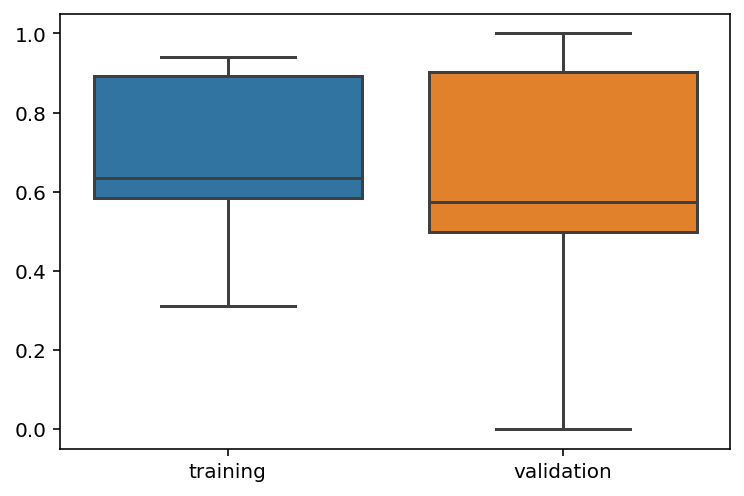

In [35]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

In [36]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [37]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids
pred_df.head()

,neg,pos,active,SMILES
0,0.998121,0.001879,0,CCc1ccc(cc1)c2nc(no2)[C@H]3CC(=O)N(C3)c4ccc(c(...
1,0.992209,0.007791,0,c1cc(cc(c1)N2CCNC2=O)NC(=O)NCC3(CC3)c4ccc(cc4)Cl
2,0.998271,0.001729,0,CCN1C(=C([C@@H](NC1=S)c2ccc(cc2)NC(=O)Nc3ccccc...
3,0.997283,0.002717,0,c1ccc(c(c1)CS(=O)(=O)Nc2cccc3c2oc(=O)[nH]3)Cl
4,0.977696,0.022304,0,CC(C)c1ccc(cc1)[C@H](C(C)C)NC(=O)C(=O)Nc2ccc(c...


In [38]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
133,0.215857,0.784143,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NCc4c...
331,0.437018,0.562982,1,c1c2c([nH]c1Br)C(=O)NCCC2=O
234,0.655874,0.344126,1,Cc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](C...
73,0.734722,0.265278,0,c1c(cc(cc1Cl)Cl)n2c3c(cn2)c(ncn3)NN
351,0.747377,0.252623,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
117,0.811945,0.188055,1,CC(=O)N1CCC(CC1)Nc2ncc3c(n2)-c4c(c(nn4C)C(=O)N...
259,0.896074,0.103926,0,c1cc(c(cc1C(F)(F)F)NC(=S)Nc2ccc3c(c2)[nH]c(=O)...
451,0.899882,0.100118,0,CCOc1ccccc1C(=O)NC(C(F)(F)F)(C(F)(F)F)Nc2c(c3c...
306,0.916303,0.083697,0,c1c(c(cc(c1N)F)F)C(=O)N(CCO)CCO
65,0.920495,0.079505,0,c1cc(c(cc1NC(=O)Nc2ccc(cc2F)Oc3ccnc4c3[nH]c(=O...


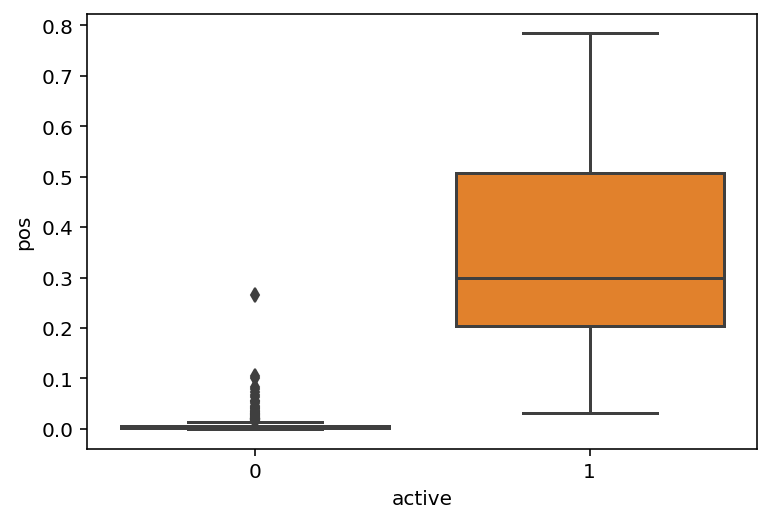

In [39]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)

In [40]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

,neg,pos,active,SMILES,Mol
68,0.968102,0.031898,1,Cc1c2ccc(cc2oc(=O)c1Cc3ccc(cc3)F)OC(=O)N(C)C,
117,0.811945,0.188055,1,CC(=O)N1CCC(CC1)Nc2ncc3c(n2)-c4c(c(nn4C)C(=O)N...,
234,0.655874,0.344126,1,Cc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](C...,
351,0.747377,0.252623,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,

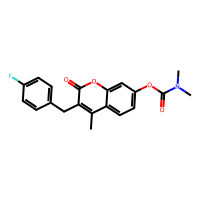
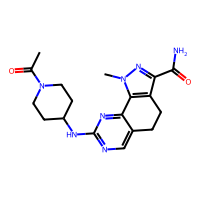
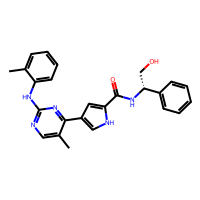
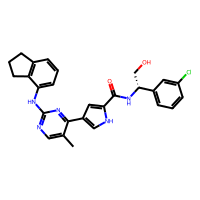

In [41]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")
false_negative_df

In [42]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")
false_positive_df

,neg,pos,active,SMILES,Mol


In [43]:
model.fit(dataset)

0.0009637546415130297

In [44]:
%cd /content

/content


In [45]:
!pip install git+https://github.com/PatWalters/rd_filters.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-kzn3i9nz
  Running command git clone -q https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-kzn3i9nz
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33803 sha256=dff55c89f56c7842dd2110471841987950d74236c22ca25f97d85c4b58ac99d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-zy7ziqgl/wheels/18/23/0c/f8d3c66d34f5ee86ae3992e1fdd45c94223ee21fcde6f01192
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=999164b29b00ee14b4083e337e98c48144dc095fac667068316b74647d0066cb
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built rd-filters docopt


In [46]:
# rd_filters.py  ChEMBL database로부터 

In [47]:
# 사용법 안내
!rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


In [48]:
!curl -o zinc_100k.smi https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/zinc_100k.smi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6159k  100 6159k    0     0  24.4M      0 --:--:-- --:--:-- --:--:-- 24.4M


In [49]:
!rd_filters filter --in zinc_100k.smi --prefix zinc

using 2 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
68410 of 100000 passed filters 68.4%
Elapsed time 83.75 seconds


In [50]:
df = pd.read_csv("zinc.csv")
df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter9_metal > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


In [51]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
2,OK,69148
7,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7713
11,Filter93_acetyl_urea > 0,1541
12,Filter78_bicyclic_Imide > 0,825


In [52]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]

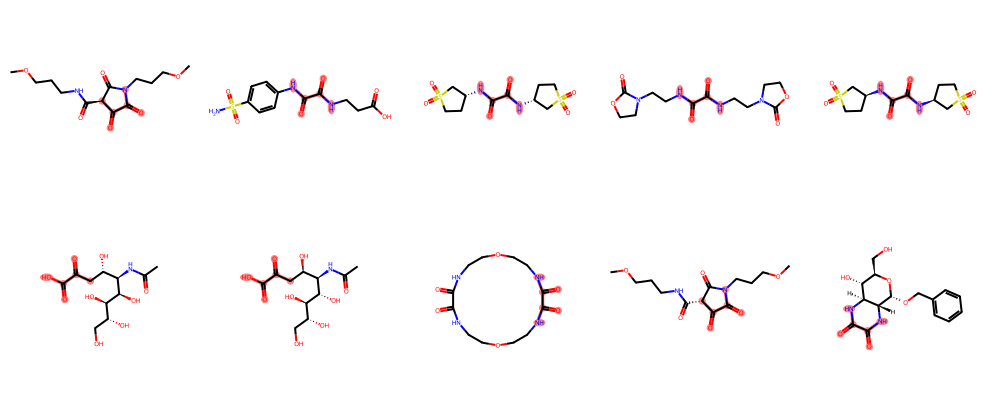

In [53]:
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
dicarbonyl = Chem.MolFromSmarts('*C(=O)C(=O)*')
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list,molsPerRow=5)


In [54]:
model = dc.models.GraphConvModel(1, batch_size=128, 
          mode='classification',model_dir="model_dir")
model.restore()

In [55]:
df = pd.read_csv("zinc_100k.smi",sep=" ",header=None)
df.columns=["SMILES","Name"]
rows,cols = df.shape
df["Val"] = [0] * rows # 피처화를 위한 빈 자리
df.head()

,SMILES,Name,Val
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,0
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,0
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,0
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0


In [56]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

In [57]:
loader = dc.data.CSVLoader(tasks=['Val'], feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(infile_name, shard_size=8192)
pred = model.predict(dataset)

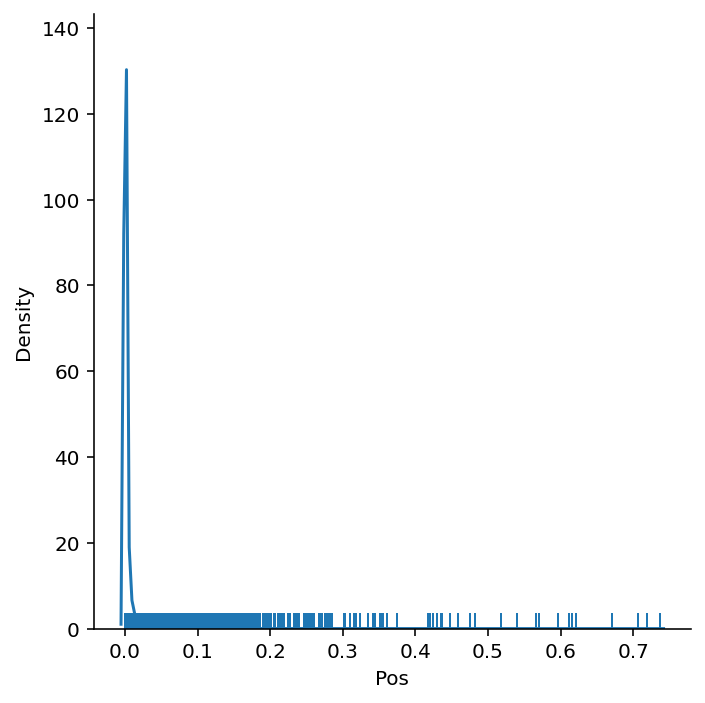

In [58]:
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])
sns.displot(x=pred_df.Pos,kind="kde",rug=True)

In [59]:
combo_df = df.join(pred_df,how="outer")
combo_df.sort_values("Pos",inplace=True,ascending=False)

In [60]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")
# combo_df.head()

In [61]:
from IPython.display import HTML
HTML(combo_df.head().to_html())

,SMILES,Name,Val,Neg,Pos,Mol
1999,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C@H]1O,ZINC000004722773,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f15e6f3be40>
309,OCCNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,ZINC000006119248,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f15eee92490>
1819,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@@H]1O,ZINC000001685071,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f161282d3f0>
1998,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@H]1O,ZINC000004722772,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f161b77aad0>
2000,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C@@H]1O,ZINC000004722774,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f160c81b990>


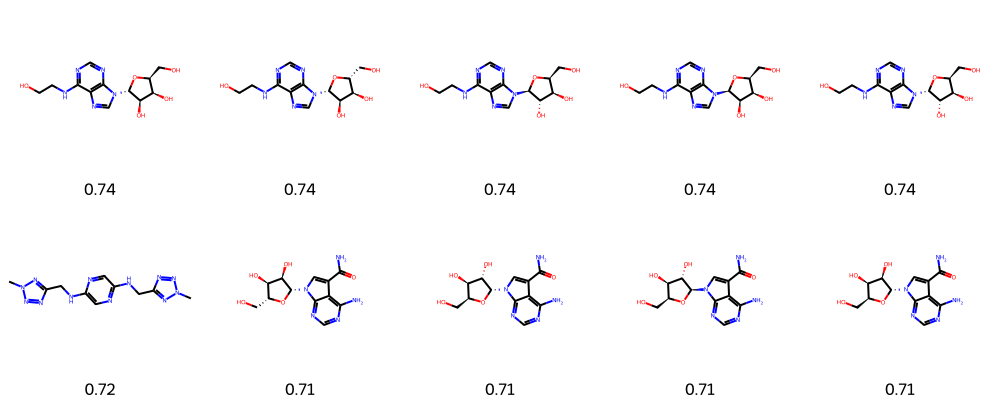

In [62]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])

In [63]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

In [64]:
best_100_df = combo_df.head(100).copy()
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)
# best_100_df.head()
HTML(best_100_df.head().to_html())

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
1999,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C@H]1O,ZINC000004722773,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f15e6f3be40>,3
309,OCCNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,ZINC000006119248,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f15eee92490>,3
1819,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@@H]1O,ZINC000001685071,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f161282d3f0>,3
1998,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@H]1O,ZINC000004722772,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f161b77aad0>,3
2000,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C@@H]1O,ZINC000004722774,0,0.263645,0.736355,<rdkit.Chem.rdchem.Mol object at 0x7f160c81b990>,3


In [65]:
len(best_100_df.Cluster.unique())
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")
best_cluster_rep_df.shape

(60, 7)

In [66]:
# 파일로 저장하기
best_cluster_rep_df.to_csv("best_cluster_represenatives.csv")